In [ ]:
#Hücre 1 – Imports & Device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cpu')

In [2]:
#Hücre 2 – Dataset & Grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
full_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

x0, y0 = full_train[0]
x0.shape, y0


(torch.Size([1, 32, 32]), 6)

In [3]:
#Hücre 3 – Train / Val Split
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

len(train_set), len(val_set), len(test_set)


(40000, 10000, 10000)

In [4]:
# Model-1: Baseline FFNN (Basit)
class FFNN_Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)


In [5]:
# Model-2: Deeper FFNN (Daha derin)
class FFNN_Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)


In [6]:
# Model-3: Regularized FFNN (Dropout + L2)
class FFNN_Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4), 
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)


In [7]:
criterion = nn.CrossEntropyLoss()


In [8]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


In [9]:
def train_and_evaluate(model_class, epochs=10, lr=1e-3, weight_decay=0.0):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
        va_loss, va_acc = run_epoch(model, val_loader, criterion, optimizer=None, train=False)

        history.append({
            "epoch": ep,
            "train_loss": tr_loss,
            "val_loss": va_loss,
            "train_acc": tr_acc,
            "val_acc": va_acc
        })
        print(f"EP {ep:02d} | tr_loss {tr_loss:.4f} va_loss {va_loss:.4f} | tr_acc {tr_acc:.4f} va_acc {va_acc:.4f}")

    # test
    te_loss, te_acc = run_epoch(model, test_loader, criterion, optimizer=None, train=False)
    print(f"TEST | loss {te_loss:.4f} acc {te_acc:.4f}")

    return model, history, te_acc


In [10]:
m1, h1, acc1 = train_and_evaluate(FFNN_Model1, epochs=10, weight_decay=0.0)
m2, h2, acc2 = train_and_evaluate(FFNN_Model2, epochs=10, weight_decay=0.0)
m3, h3, acc3 = train_and_evaluate(FFNN_Model3, epochs=10, weight_decay=1e-4)

acc1, acc2, acc3


EP 01 | tr_loss 2.0617 va_loss 1.9668 | tr_acc 0.2473 va_acc 0.2972
EP 02 | tr_loss 1.9315 va_loss 1.9140 | tr_acc 0.3079 va_acc 0.3180
EP 03 | tr_loss 1.8695 va_loss 1.8647 | tr_acc 0.3343 va_acc 0.3369
EP 04 | tr_loss 1.8264 va_loss 1.8237 | tr_acc 0.3510 va_acc 0.3572
EP 05 | tr_loss 1.8032 va_loss 1.8271 | tr_acc 0.3599 va_acc 0.3434
EP 06 | tr_loss 1.7784 va_loss 1.7946 | tr_acc 0.3701 va_acc 0.3628
EP 07 | tr_loss 1.7579 va_loss 1.7837 | tr_acc 0.3803 va_acc 0.3650
EP 08 | tr_loss 1.7363 va_loss 1.7817 | tr_acc 0.3855 va_acc 0.3689
EP 09 | tr_loss 1.7195 va_loss 1.7866 | tr_acc 0.3914 va_acc 0.3653
EP 10 | tr_loss 1.7063 va_loss 1.7466 | tr_acc 0.3993 va_acc 0.3845
TEST | loss 1.7468 acc 0.3860
EP 01 | tr_loss 2.0488 va_loss 1.9575 | tr_acc 0.2473 va_acc 0.2904
EP 02 | tr_loss 1.9112 va_loss 1.8921 | tr_acc 0.3121 va_acc 0.3135
EP 03 | tr_loss 1.8488 va_loss 1.8368 | tr_acc 0.3352 va_acc 0.3456
EP 04 | tr_loss 1.7970 va_loss 1.8048 | tr_acc 0.3595 va_acc 0.3578
EP 05 | tr_loss 1.

(0.386, 0.4005, 0.339)

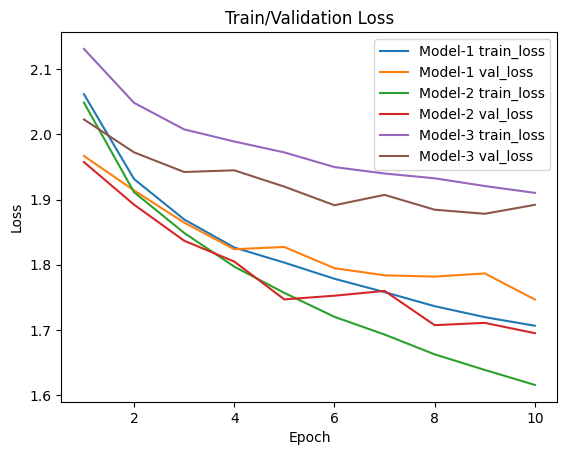

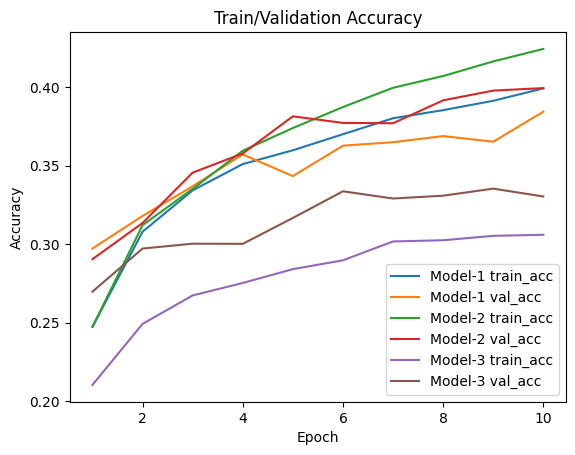

In [11]:
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    # histories: [h1, h2, h3] gibi listeler
    # labels: ["Model-1", "Model-2", "Model-3"] gibi

    plt.figure()
    for h, lab in zip(histories, labels):
        epochs = [d["epoch"] for d in h]
        tr_loss = [d["train_loss"] for d in h]
        va_loss = [d["val_loss"] for d in h]
        plt.plot(epochs, tr_loss, label=f"{lab} train_loss")
        plt.plot(epochs, va_loss, label=f"{lab} val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

    plt.figure()
    for h, lab in zip(histories, labels):
        epochs = [d["epoch"] for d in h]
        tr_acc = [d["train_acc"] for d in h]
        va_acc = [d["val_acc"] for d in h]
        plt.plot(epochs, tr_acc, label=f"{lab} train_acc")
        plt.plot(epochs, va_acc, label=f"{lab} val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train/Validation Accuracy")
    plt.legend()
    plt.show()

plot_history([h1, h2, h3], ["Model-1", "Model-2", "Model-3"])


In [12]:
best_model = m2


In [13]:
# Q2-a — Pixel Gauss Fuzzing (test image input attack)
import copy
import math

def pixel_gauss_fuzz_batch(images, mu=0.0, sigma=0.8, p=0.1):
    """
    images: (B, 1, 32, 32) in [0,1]
    p: her pikselin bozulma olasılığı (random seçilen piksel mantığı)
    mu, sigma: Gaussian N(mu, sigma^2)
    """
    images = images.clone()
    mask = (torch.rand_like(images) < p)
    noise = torch.normal(mean=mu, std=sigma, size=images.shape, device=images.device)
    images[mask] = images[mask] + noise[mask]
    images = torch.clamp(images, 0.0, 1.0)
    return images


In [14]:
# Hücre: “Fuzzed test” misclassification hesapla
def misclassification_rate_with_input_fuzz(model, loader, mu=0.0, sigma=0.8, p=0.1):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            fuzzed = pixel_gauss_fuzz_batch(imgs, mu=mu, sigma=sigma, p=p)
            logits = model(fuzzed)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    return 1 - acc


In [15]:
# Hücre: farklı (μ, δ) dene ve tablo yap
configs = [
    (0.0, 0.2),
    (0.0, 0.5),
    (0.0, 0.8),
    (0.0, 1.0),
    (0.1, 0.8),
    (-0.1, 0.8),
]

p = 0.10  # “kaç piksel bozulacak” kontrolü; istersen 0.05 ve 0.2 de denersin

results_pgf = []
for mu, sigma in configs:
    mr = misclassification_rate_with_input_fuzz(best_model, test_loader, mu=mu, sigma=sigma, p=p)
    results_pgf.append((mu, sigma, p, mr))
    print(f"PGF mu={mu:+.2f} sigma={sigma:.2f} p={p:.2f} -> misclf={mr:.4f}")

results_pgf


PGF mu=+0.00 sigma=0.20 p=0.10 -> misclf=0.5969
PGF mu=+0.00 sigma=0.50 p=0.10 -> misclf=0.6042
PGF mu=+0.00 sigma=0.80 p=0.10 -> misclf=0.6067
PGF mu=+0.00 sigma=1.00 p=0.10 -> misclf=0.6085
PGF mu=+0.10 sigma=0.80 p=0.10 -> misclf=0.6054
PGF mu=-0.10 sigma=0.80 p=0.10 -> misclf=0.6087


[(0.0, 0.2, 0.1, 0.5969),
 (0.0, 0.5, 0.1, 0.6042000000000001),
 (0.0, 0.8, 0.1, 0.6067),
 (0.0, 1.0, 0.1, 0.6085),
 (0.1, 0.8, 0.1, 0.6053999999999999),
 (-0.1, 0.8, 0.1, 0.6087)]

In [16]:
# Q2-b — Weight Gauss Fuzzing (model weights attack)
def weight_gauss_fuzz_inplace(model, mu=0.0, sigma=0.1):
    with torch.no_grad():
        for param in model.parameters():
            noise = torch.normal(mean=mu, std=sigma, size=param.shape, device=param.device)
            param.add_(noise)


In [17]:
# Hücre: kopya model oluştur ve boz
def misclassification_rate_with_weight_fuzz(original_model, loader, mu=0.0, sigma=0.1):
    # eğitilmiş modeli bozmamak için kopya
    fuzzed_model = copy.deepcopy(original_model)
    fuzzed_model.to(device)

    weight_gauss_fuzz_inplace(fuzzed_model, mu=mu, sigma=sigma)

    # orijinal test image üzerinde değerlendir
    fuzzed_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = fuzzed_model(imgs)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    return 1 - acc


In [18]:
# Hücre: farklı ağırlık bozmaları dene
weight_configs = [
    (0.0, 0.01),
    (0.0, 0.05),
    (0.0, 0.10),
    (0.0, 0.20),
    (0.02, 0.10),
    (-0.02, 0.10),
]

results_wgf = []
for mu, sigma in weight_configs:
    mr = misclassification_rate_with_weight_fuzz(best_model, test_loader, mu=mu, sigma=sigma)
    results_wgf.append((mu, sigma, mr))
    print(f"WGF mu={mu:+.2f} sigma={sigma:.2f} -> misclf={mr:.4f}")

results_wgf


WGF mu=+0.00 sigma=0.01 -> misclf=0.6027
WGF mu=+0.00 sigma=0.05 -> misclf=0.6859
WGF mu=+0.00 sigma=0.10 -> misclf=0.7754
WGF mu=+0.00 sigma=0.20 -> misclf=0.8667
WGF mu=+0.02 sigma=0.10 -> misclf=0.9000
WGF mu=-0.02 sigma=0.10 -> misclf=0.8922


[(0.0, 0.01, 0.6027),
 (0.0, 0.05, 0.6859),
 (0.0, 0.1, 0.7754),
 (0.0, 0.2, 0.8667),
 (0.02, 0.1, 0.9),
 (-0.02, 0.1, 0.8922)]